In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Load RGB images from data1.h5
def load_dataset(path):
  return np.array(h5py.File(path)["data"])

rgb_images = load_dataset("/content/drive/MyDrive/Homework/NN_Mini/data1.h5")
print(rgb_images.shape)

(10240, 3, 16, 16)


In [ ]:
#Convert RGB images to greyscale
#Y = 0.2126 ∗ R + 0.7152 ∗ G + 0.0722 ∗ B                                                                                                                                                                                                                                                                                                                                                                                                                                       
gray_image = 0.2126 * rgb_images[:,0,:,:] + 0.7152 * rgb_images[:,1,:,:] + 0.0722 * rgb_images[:,2,:,:]
#Remove the mean pixel intensity of each image from itself
gray_image = gray_image.reshape(gray_image.shape[0],gray_image.shape[1]*gray_image.shape[2])
mean_arr = np.mean(gray_image,axis = 1,keepdims=True)
grey_image = gray_image - mean_arr
#clip, normalize, map
std = np.std(gray_image)
gray_image = np.clip(gray_image,-3*std,3*std)
gray_image = (gray_image - gray_image.min()) / (gray_image.max() - gray_image.min()) #data ranges 0 to 1
gray_image = 0.1 + gray_image*0.9 #data ranges 0.1 to 0.9
gray_image = gray_image.reshape(-1,16,16)
#Reshape rgb to (10240,16,16,3)
rgb_images = np.transpose(rgb_images,(0,2,3,1))

In [ ]:
#Plot random 200 samples
fig_gray, ax_gray = plt.subplots(20,10,figsize=(10,20))
fig_rgb, ax_rgb = plt.subplots(20,10,figsize=(10,20))

for i in range(20):
  for j in range(10):
    image_index = np.random.randint(0,gray_image.shape[0])
    ax_gray[i,j].imshow(gray_image[image_index],cmap="gray")
    ax_gray[i,j].axis("off")
    ax_rgb[i,j].imshow(rgb_images[image_index])
    ax_rgb[i,j].axis("off")

fig_gray.savefig("gray.png")
fig_rgb.savefig("rgb.png")
plt.close("all")

In [ ]:
#WX.T +b
def init_parameters(l_pre,l_post):
  np.random.seed(33)
  w0 = np.sqrt(6/(l_pre + l_post))

  W1 = np.random.uniform(-w0,w0, size=(l_post,l_pre))
  b1 = np.random.uniform(-w0,w0, size=(l_post,1))
  W2 = np.random.uniform(-w0,w0, size=(l_pre,l_post))
  b2 = np.random.uniform(-w0,w0, size=(l_pre,1))

  We = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}
  return We

In [ ]:
#Returns the output and the derivative of activation function
def sigmoid(Z):  
  A = 1 / (1 + np.exp(-Z))
  derivative = (1-A)*A  
  return A,derivative

In [ ]:
def forward_propagate(We,data):  
  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]

  Z1 = np.matmul(W1,data.T) + b1
  A1, d_activation_1 = sigmoid(Z1)
  Z2 = np.matmul(W2,A1) + b2
  A2, d_activation_2 = sigmoid(Z2)
  
  return (Z1,A1,Z2,A2,d_activation_1,d_activation_2)

In [ ]:
#Does forward and back propagation, calculates cost and related gradients
def aeCost(We,data,params):
  N = data.shape[0]

  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]

  l_in = params["Lin"]
  l_hid = params["Lhid"]
  lambda_ = params["lambda"]
  beta = params["beta"]
  rho = params["rho"]

  data = data.reshape(N,256)
  #Forward propogate
  Z1,A1,Z2,A2,d_activation_1,d_activation_2 = forward_propagate(We,data)
  
  #Calculate cost  
  avarage_squared_error = (1/(2*N)) * (np.sum(np.linalg.norm(data.T-A2)**2))
  tykhonov_regularization = lambda_* 0.5 * (np.sum(np.square(W1))+np.sum(np.square(W2)))
  p_j = np.mean(A1,axis=1,keepdims=True)
  kl_divergence = beta*np.sum(rho*np.log(rho/p_j) + (1-rho)*np.log((1-rho)/(1-p_j)))
  J = avarage_squared_error + tykhonov_regularization + kl_divergence

  #Backward propagate and J_grad
  dA2 = (1/N)*(data.T - A2) * -1
  dZ2 = dA2 * d_activation_2
  dA1 = np.matmul(W2.T,dZ2) + beta * (-(rho/p_j) + (1-rho)/(1-p_j))
  dZ1 = dA1 * d_activation_1
  d_tykhonov_1 = lambda_* W1
  d_tykhonov_2 = lambda_ * W2
  dW1 = (np.matmul(dZ1,data) + d_tykhonov_1)
  db1 = np.sum(dZ1,axis=1,keepdims=True)  
  dW2 = (np.matmul(dZ2,A1.T) + d_tykhonov_2)
  db2 = np.sum(dZ2,axis=1,keepdims=True)

  J_grad = {"dW1":dW1,"dW2":dW2,"db1":db1,"db2":db2}
  #print(f"MSE={avarage_squared_error} KL={kl_divergence} REG={tykhonov_regularization} TOTAL={J}")
  return J,J_grad    

In [ ]:
def update_parameters(We,J_grad,learning_rate,change_dict,momentum_rate):
  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]

  dW1 = J_grad["dW1"]
  dW2 = J_grad["dW2"]
  db1 = J_grad["db1"]
  db2 = J_grad["db2"]

  c_W1 = change_dict["W1"]
  c_W2 = change_dict["W2"]
  c_b1 = change_dict["b1"]
  c_b2 = change_dict["b2"]

  delta_W1 = learning_rate*dW1 + c_W1*momentum_rate
  delta_W2 = learning_rate*dW2 + c_W2*momentum_rate
  delta_b1 = learning_rate*db1 + c_b1*momentum_rate
  delta_b2 = learning_rate*db2 + c_b2*momentum_rate

  W1 = W1 - delta_W1
  W2 = W2 - delta_W2
  b1 = b1 - delta_b1
  b2 = b2 - delta_b2

  We = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}
  change_dict = {"W1":delta_W1,"b1":delta_b1,"W2":delta_W2,"b2":delta_b2}
  return We,change_dict


In [ ]:
def gradient_descent(We,params,data,epoch,learning_rate,change_dict,momentum_rate,batch_size):
  N = data.shape[0]
  iteration_per_epoch = int(N / batch_size)
  for i in range(epoch):
    mini_batch_start_index = 0
    mini_batch_end_index = batch_size
    sample_order = np.random.permutation(N)
    data = data[sample_order]
    J_mean = 0
    for j in range(iteration_per_epoch):
      mini_batch_data = data[mini_batch_start_index:mini_batch_end_index]      
      J,J_grad = aeCost(We,mini_batch_data,params)
      We,change_dict = update_parameters(We,J_grad,learning_rate,change_dict,momentum_rate)
      mini_batch_start_index = mini_batch_end_index
      mini_batch_end_index = mini_batch_end_index + batch_size
      J_mean = J_mean + J

    J_mean = J_mean / iteration_per_epoch
    print(f"Epoch = {i+1} ---> Training error: {J_mean}")  
  
  return We

In [ ]:
We = init_parameters(256,64)
params = {"Lin":256, "Lhid":64, "lambda":5e-4, "beta":0.01,"rho":0.03}
change_dict = {"W1":0,"b1":0,"W2":0,"b2":0}
We = gradient_descent(We,params,gray_image,200,0.6,change_dict,0.4,32)

Epoch = 1 ---> Training error: 2.5729349331880074
Epoch = 2 ---> Training error: 1.9271595061790872
Epoch = 3 ---> Training error: 1.8093354126755465
Epoch = 4 ---> Training error: 1.7458568420890501
Epoch = 5 ---> Training error: 1.670440403466941
Epoch = 6 ---> Training error: 1.613556325443735
Epoch = 7 ---> Training error: 1.5780343015469345
Epoch = 8 ---> Training error: 1.5611792472514172
Epoch = 9 ---> Training error: 1.5481201569846115
Epoch = 10 ---> Training error: 1.5352672658871955
Epoch = 11 ---> Training error: 1.522963149466696
Epoch = 12 ---> Training error: 1.5105196260632427
Epoch = 13 ---> Training error: 1.4984065903805233
Epoch = 14 ---> Training error: 1.490007127637374
Epoch = 15 ---> Training error: 1.4792676829153186
Epoch = 16 ---> Training error: 1.4702029277244915
Epoch = 17 ---> Training error: 1.4619876120285453
Epoch = 18 ---> Training error: 1.4537566958784183
Epoch = 19 ---> Training error: 1.4470500755781266
Epoch = 20 ---> Training error: 1.4409989472

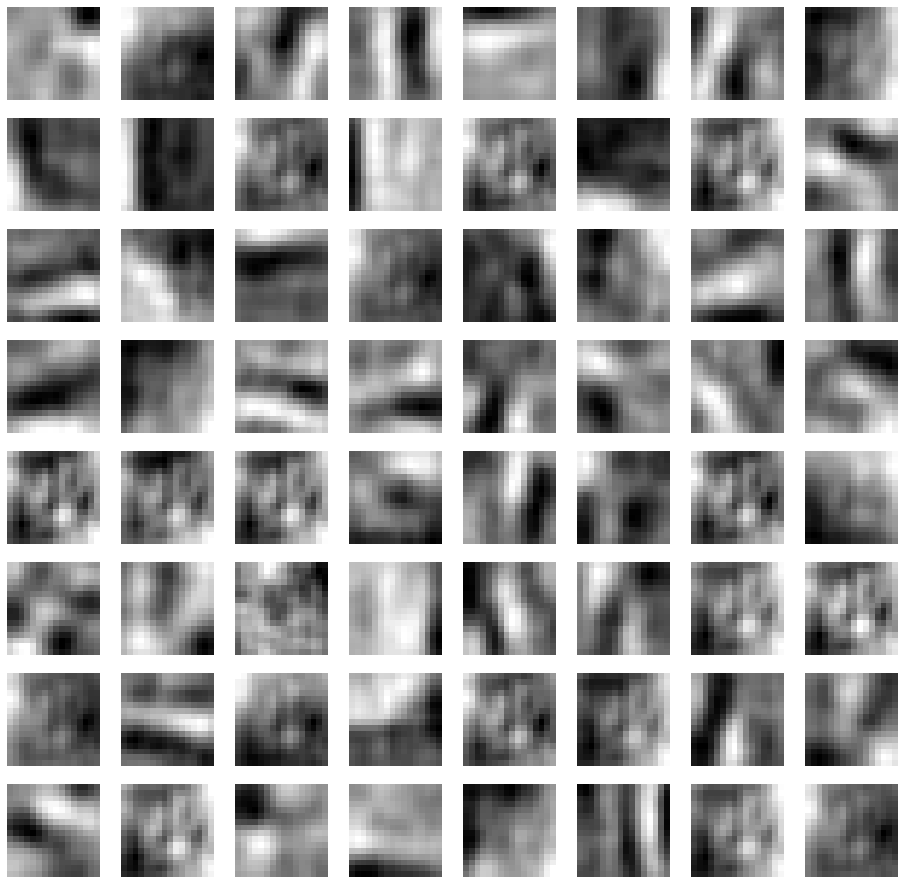

In [ ]:
#plot weights
fig_w, ax_w = plt.subplots(8,8,figsize=(16,16))
neuron_number = 0
for i in range(8):
  for j in range(8):
    ax_w[i,j].imshow(We["W1"][neuron_number].reshape(16,16),cmap="gray")
    ax_w[i,j].axis("off")
    neuron_number = neuron_number + 1

In [ ]:
We = init_parameters(256,81)
params = {"Lin":256, "Lhid":81, "lambda":0, "beta":0.01,"rho":0.03}
change_dict = {"W1":0,"b1":0,"W2":0,"b2":0}
We = gradient_descent(We,params,gray_image,200,0.6,change_dict,0.4,32)

Epoch = 1 ---> Training error: 2.5065230676530366
Epoch = 2 ---> Training error: 1.8027096153008515
Epoch = 3 ---> Training error: 1.6475997355962466
Epoch = 4 ---> Training error: 1.5099608020205977
Epoch = 5 ---> Training error: 1.384773188159471
Epoch = 6 ---> Training error: 1.3049108804924388
Epoch = 7 ---> Training error: 1.2506024473514132
Epoch = 8 ---> Training error: 1.1975993503467524
Epoch = 9 ---> Training error: 1.1495933682554293
Epoch = 10 ---> Training error: 1.1046307681278837
Epoch = 11 ---> Training error: 1.0648531610912835
Epoch = 12 ---> Training error: 1.0305304417893444
Epoch = 13 ---> Training error: 1.0022567814689096
Epoch = 14 ---> Training error: 0.9771807543577161
Epoch = 15 ---> Training error: 0.9535088527626929
Epoch = 16 ---> Training error: 0.9331476329099759
Epoch = 17 ---> Training error: 0.9175614639999712
Epoch = 18 ---> Training error: 0.9025448301491655
Epoch = 19 ---> Training error: 0.891417414861938
Epoch = 20 ---> Training error: 0.87948533

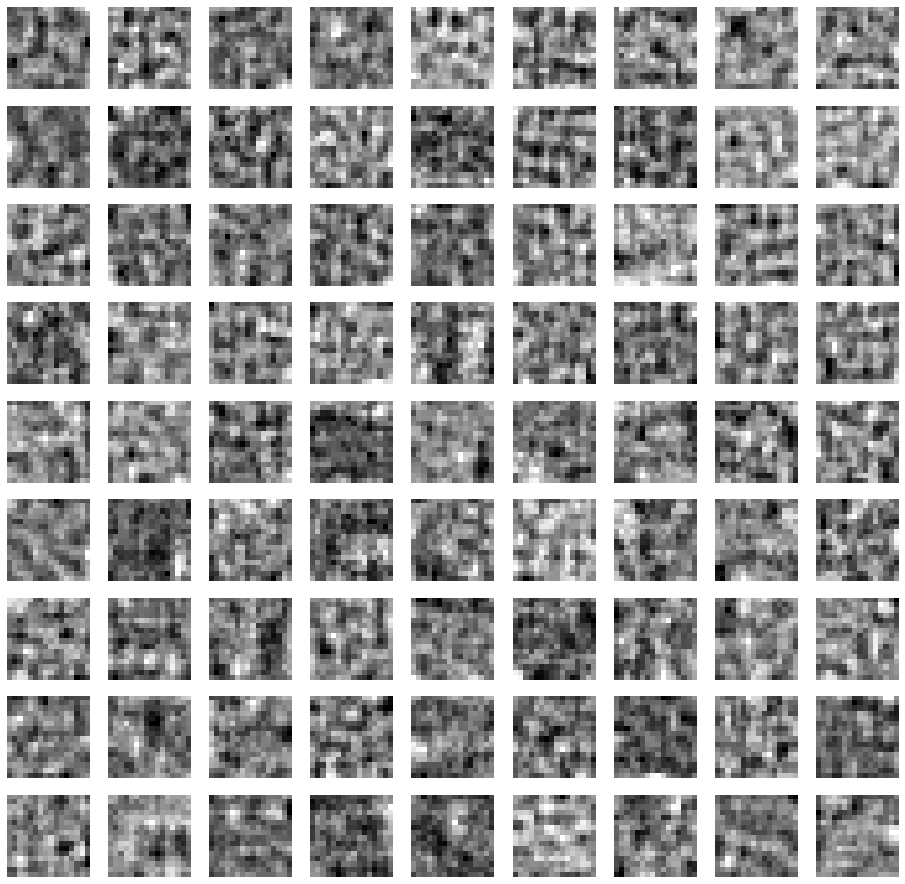

In [ ]:
#plot weights
fig_w, ax_w = plt.subplots(9,9,figsize=(16,16))
neuron_number = 0
for i in range(9):
  for j in range(9):
    ax_w[i,j].imshow(We["W1"][neuron_number].reshape(16,16),cmap="gray")
    ax_w[i,j].axis("off")
    neuron_number = neuron_number + 1

In [ ]:
#Question 2
a = np.array(h5py.File("/content/drive/MyDrive/Homework/NN_Mini/data2.h5"))
print(a)

['testd' 'testx' 'traind' 'trainx' 'vald' 'valx' 'words']


In [ ]:
def load_word_dataset(path):
  x_train = np.array(h5py.File(path)["trainx"]).T
  y_train = np.array(h5py.File(path)["traind"]).T
  x_val = np.array(h5py.File(path)["valx"]).T
  y_val = np.array(h5py.File(path)["vald"]).T
  x_test = np.array(h5py.File(path)["testx"]).T
  y_test = np.array(h5py.File(path)["testd"]).T
  words = np.array(h5py.File(path)["words"])

  return x_train,y_train,x_val,y_val,x_test,y_test,words

In [ ]:
x_train,y_train,x_val,y_val,x_test,y_test,words = load_word_dataset("/content/drive/MyDrive/Homework/NN_Mini/data2.h5")
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
print(words.shape)

(3, 372500)
(372500,)
(3, 46500)
(46500,)
(3, 46500)
(46500,)
(250,)


In [ ]:
print(x_train.min())

1


In [ ]:
print(words)

[b'all' b'set' b'just' b'show' b'being' b'money' b'over' b'both' b'years'
 b'four' b'through' b'during' b'go' b'still' b'children' b'before'
 b'police' b'office' b'million' b'also' b'less' b'had' b',' b'including'
 b'should' b'to' b'only' b'going' b'under' b'has' b'might' b'do' b'them'
 b'good' b'around' b'get' b'very' b'big' b'dr.' b'game' b'every' b'know'
 b'they' b'not' b'world' b'now' b'him' b'school' b'several' b'like' b'did'
 b'university' b'companies' b'these' b'she' b'team' b'found' b'where'
 b'right' b'says' b'people' b'house' b'national' b'some' b'back' b'see'
 b'street' b'are' b'year' b'home' b'best' b'out' b'even' b'what' b'said'
 b'for' b'federal' b'since' b'its' b'may' b'state' b'does' b'john'
 b'between' b'new' b';' b'three' b'public' b'?' b'be' b'we' b'after'
 b'business' b'never' b'use' b'here' b'york' b'members' b'percent' b'put'
 b'group' b'come' b'by' b'$' b'on' b'about' b'last' b'her' b'of' b'could'
 b'days' b'against' b'times' b'women' b'place' b'think' b'first' b

In [ ]:
#Returns the output and the derivative of activation function
def sigmoid(Z):  
  A = 1 / (1 + np.exp(-Z))
  derivative = (1-A)*A  
  return A,derivative

In [ ]:
#WX + b
def init(D,P):
  np.random.seed(33)
  word_embedding = np.random.normal(0,0.01,(250,D))
  W1 = np.random.normal(0,0.01,(P,3*D))
  b1 = np.random.normal(0,0.01,(P,1))
  W2 = np.random.normal(0,0.01,(250,P))
  b2 = np.random.normal(0,0.01,(250,1))
  We = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}
  return word_embedding,We

In [ ]:
def word_embedding_to_input_vector(word_embedding,x_train):
  N = x_train.shape[1]
  D = word_embedding.shape[1]
  input_vector = np.zeros((3*D,N))
  for i in range(N):
    first_word = word_embedding[x_train[0,i]-1,:]
    second_word = word_embedding[x_train[1,i]-1,:]
    third_word = word_embedding[x_train[2,i]-1,:]

    concat = np.concatenate((first_word,second_word,third_word))
    concat = concat.T
    input_vector[:,i] = concat
  
  return input_vector

In [ ]:
def cross_entropy(y_pred,y):  
  return -np.sum(y*np.log(y_pred)) / y_pred.shape[1]

In [ ]:
def forward_propagate(We,data):
  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]
  
  Z1 = np.matmul(W1,data) + b1  
  A1, d_activation_1 = sigmoid(Z1)
  Z2 = np.matmul(W2,A1) + b2 
  #calculate softmax
  exps = np.exp(Z2-np.amax(Z2,axis=0)) #overcome exponential related overflows  
  A2 = exps/np.sum(exps,axis=0)
  return (Z1,A1,Z2,A2,d_activation_1)  

In [ ]:
#Make y arrays one hot encoded
def y_to_one_hot_encoded(y):
  return np.eye(250)[:, y.ravel()-1]

In [ ]:
y_train_ =  y_to_one_hot_encoded(y_train)
y_val_ =  y_to_one_hot_encoded(y_val)
y_test_ =  y_to_one_hot_encoded(y_test)
print(y_train_.shape)
print(y_val_.shape)
print(y_test_.shape)

(250, 372500)
(250, 46500)
(250, 46500)


In [ ]:
def cost(We,word_embedding,x_train,y_train_):
  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]

  #Create input vectors for training and validation
  input_vector_train = word_embedding_to_input_vector(word_embedding,x_train)  

  #Forward propagate for training
  (Z1,A1,Z2,A2,d_activation_1) = forward_propagate(We,input_vector_train)

  #Calculate training cost for this batch
  batch_training_cost = cross_entropy(A2,y_train_)  

  #Backward propagate    
  dZ2 = A2 - y_train_
  dA1 = np.matmul(W2.T,dZ2)
  dZ1 = dA1 * d_activation_1 
  dW1 = np.matmul(dZ1,input_vector_train.T)
  db1 = np.sum(dZ1,axis=1,keepdims=True)  
  dW2 = np.matmul(dZ2,A1.T)
  db2 = np.sum(dZ2,axis=1,keepdims=True)
  dA0 = np.matmul(W1.T,dZ1) #gradient for the input vector

  grads={"dW1":dW1,"dW2":dW2,"db1":db1,"db2":db2,"dA0":dA0}
  return batch_training_cost, grads

In [ ]:
def update_parameters(We,grads,learning_rate,word_embedding,x_train,start_index,end_index,momentum_dict,momentum_rate):
  dW1 = grads["dW1"]
  dW2 = grads["dW2"]
  db1 = grads["db1"]
  db2 = grads["db2"]
  dA0 = grads["dA0"]

  W1 = We["W1"]
  W2 = We["W2"]
  b1 = We["b1"]
  b2 = We["b2"]

  cW1 = momentum_dict["cW1"]
  cW2 = momentum_dict["cW2"]
  cb1 = momentum_dict["cb1"]
  cb2 = momentum_dict["cb2"]
  cA0 = momentum_dict["cA0"]

  #Update word_embedding grads
  word_count = word_embedding.shape[0]
  D = word_embedding.shape[1]
  x_grad = np.zeros((word_count,D))

  #Sum grads for same words
  for i in range(end_index-start_index):
    triagram = dA0[:,i].T
    first_word_grad = triagram[0:D]
    second_word_grad = triagram[D:2*D]
    third_word_grad = triagram[2*D:]

    x_grad[(x_train[0][start_index+i])-1,:] += first_word_grad
    x_grad[(x_train[1][start_index+i])-1,:] += second_word_grad
    x_grad[(x_train[2][start_index+i])-1,:] += third_word_grad

  #word_embedding = word_embedding - learning_rate * x_grad

  delta_word_embedding = learning_rate * x_grad  + momentum_rate * cA0
  delta_W1 = learning_rate * dW1 + momentum_rate * cW1 
  delta_W2 = learning_rate * dW2  + momentum_rate * cW2
  delta_b1 = learning_rate * db1  + momentum_rate * cb1
  delta_b2 = learning_rate * db2 + momentum_rate * cb2
  #Update
  W1 = W1 - delta_W1
  W2 = W2 - delta_W2
  b1 = b1 - delta_b1
  b2 = b2 - delta_b2
  word_embedding = word_embedding - delta_word_embedding

  We = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}
  momentum_dict = {"cW1":delta_W1,"cW2":delta_W2,"cb1":delta_b1,"cb2":delta_b2,"cA0":delta_word_embedding}
  return We,word_embedding,momentum_dict 

In [ ]:
def gradient_descent(We,epoch,learning_rate,batch_size,x_train,y_train_,x_val,y_val_,word_embedding,momentum_dict,momentum_rate):
  N = x_train.shape[1]
  iteration_per_epoch = int(N / batch_size)
  validation_cost = []
  training_cost = []
  for i in range(epoch):
    mini_batch_start_index = 0
    mini_batch_end_index = batch_size
    sample_order = np.random.permutation(N)
    x_train = x_train[:,sample_order]
    y_train_ = y_train_[:,sample_order]
    train_per_batch = []
    
    for j in range(iteration_per_epoch):      
      mini_batch_data_x = x_train[:,mini_batch_start_index:mini_batch_end_index]
      mini_batch_data_y = y_train_[:,mini_batch_start_index:mini_batch_end_index]      
      J,grads = cost(We,word_embedding,mini_batch_data_x,mini_batch_data_y)      
      We,word_embedding,momentum_dict = update_parameters(We,grads,learning_rate,word_embedding,x_train,mini_batch_start_index,mini_batch_end_index,momentum_dict,momentum_rate)
      mini_batch_start_index = mini_batch_end_index
      mini_batch_end_index = mini_batch_end_index + batch_size
      train_per_batch.append(J)

      if mini_batch_end_index > N:
        mini_batch_end_index = N 

    #Training cost
    training_cost_per_epoch = np.mean(train_per_batch)
    training_cost.append(training_cost_per_epoch)
    #calculate validation cost
    val_input_vector = word_embedding_to_input_vector(word_embedding,x_val)    
    (Z1,A1,Z2,A2_val,d_activation_1) = forward_propagate(We,val_input_vector)    
    val_cost = cross_entropy(A2_val,y_val_)
    print(f"Epoch = {i+1} ---> Validation cost: {val_cost} Training cost:{training_cost_per_epoch}")
    validation_cost.append(val_cost)
    if len(validation_cost) > 1:
      delta_err = np.abs(validation_cost[-1] - validation_cost[-2])
      if delta_err < 1e-5:
        print("Training will be stopped because of low validation delta")


  return We,word_embedding,momentum_dict,validation_cost,training_cost


In [ ]:
word_embedding,We = init(32,256)
momentum_dict = {"cW1":0,"cW2":0,"cb1":0,"cb2":0,"cA0":0}
We, word_embedding,momentum_dict,validation_cost,training_cost = gradient_descent(We,50,0.0006,200,x_train,y_train_,x_val,y_val_,word_embedding,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 4.144271920623266 Training cost:4.402067476959753
Epoch = 2 ---> Validation cost: 3.559721830187325 Training cost:3.885621005230388
Epoch = 3 ---> Validation cost: 3.213154039474262 Training cost:3.349123915509387
Epoch = 4 ---> Validation cost: 3.058155479173783 Training cost:3.117202603371904
Epoch = 5 ---> Validation cost: 2.9425202888237996 Training cost:2.9933065109662698
Epoch = 6 ---> Validation cost: 2.8771815411507395 Training cost:2.9071258705293976
Epoch = 7 ---> Validation cost: 2.823463607228771 Training cost:2.84345795878757
Epoch = 8 ---> Validation cost: 2.7832373879709813 Training cost:2.791168218707632
Epoch = 9 ---> Validation cost: 2.7457511864171247 Training cost:2.748015387041531
Epoch = 10 ---> Validation cost: 2.7190994031794844 Training cost:2.7095979125664913
Epoch = 11 ---> Validation cost: 2.7070631359050052 Training cost:2.67747201839053
Epoch = 12 ---> Validation cost: 2.680090258493841 Training cost:2.649049673994794
Epoch 

In [ ]:
word_embedding,We_2 = init(16,128)
momentum_dict = {"cW1":0,"cW2":0,"cb1":0,"cb2":0,"cA0":0}
We_2, word_embedding,momentum_dict,validation_cost_2,training_cost_2 = gradient_descent(We_2,50,0.0006,200,x_train,y_train_,x_val,y_val_,word_embedding,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 4.095337994858527 Training cost:4.3629777038668545
Epoch = 2 ---> Validation cost: 3.5452736578805117 Training cost:3.8501419183022745
Epoch = 3 ---> Validation cost: 3.232083308663109 Training cost:3.3594482524336287
Epoch = 4 ---> Validation cost: 3.070881905181356 Training cost:3.1383910931802377
Epoch = 5 ---> Validation cost: 2.984798535001497 Training cost:3.020800757999861
Epoch = 6 ---> Validation cost: 2.9175072424370003 Training cost:2.937243748654612
Epoch = 7 ---> Validation cost: 2.872094965005444 Training cost:2.8757490687753546
Epoch = 8 ---> Validation cost: 2.821496213698354 Training cost:2.828989936010972
Epoch = 9 ---> Validation cost: 2.7962709320570167 Training cost:2.7921115894163275
Epoch = 10 ---> Validation cost: 2.772559777596394 Training cost:2.762347454041948
Epoch = 11 ---> Validation cost: 2.7489195798061763 Training cost:2.737150179120883
Epoch = 12 ---> Validation cost: 2.738392092076305 Training cost:2.7157691795789334
Ep

In [ ]:
word_embedding,We_3 = init(8,64)
momentum_dict = {"cW1":0,"cW2":0,"cb1":0,"cb2":0,"cA0":0}
We_3, word_embedding,momentum_dict,validation_cost_3,training_cost_3 = gradient_descent(We_3,50,0.0006,200,x_train,y_train_,x_val,y_val_,word_embedding,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 4.070835043585274 Training cost:4.329629873475752
Epoch = 2 ---> Validation cost: 3.5518661899322606 Training cost:3.819169085382834
Epoch = 3 ---> Validation cost: 3.257637679138272 Training cost:3.3793480890863563
Epoch = 4 ---> Validation cost: 3.1160613842408433 Training cost:3.178127415116891
Epoch = 5 ---> Validation cost: 3.033678833035001 Training cost:3.0710472875964476
Epoch = 6 ---> Validation cost: 2.987421962054741 Training cost:3.002827615763132
Epoch = 7 ---> Validation cost: 2.9553230490920086 Training cost:2.958081851487027
Epoch = 8 ---> Validation cost: 2.9246866341879065 Training cost:2.924728959182639
Epoch = 9 ---> Validation cost: 2.899168395126575 Training cost:2.898904485870411
Epoch = 10 ---> Validation cost: 2.887302609745168 Training cost:2.878430451363563
Epoch = 11 ---> Validation cost: 2.8674792441315735 Training cost:2.8627340492523823
Epoch = 12 ---> Validation cost: 2.8588697447278304 Training cost:2.850203497273769
Epoc

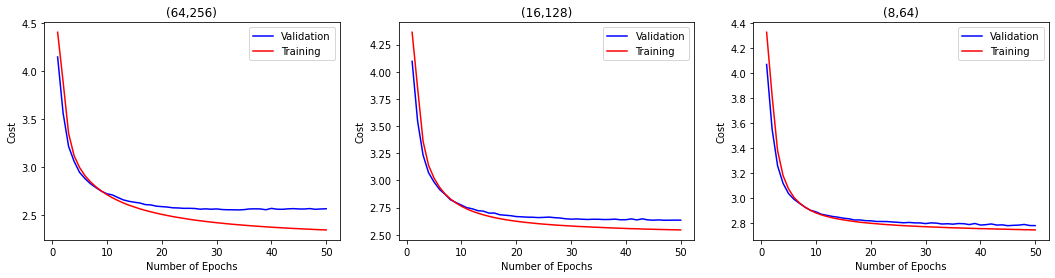

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot([x for x in range(1,len(validation_cost)+1)],validation_cost,color="blue",label="Validation")
ax[0].plot([x for x in range(1,len(training_cost)+1)],training_cost,color="red",label="Training")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Cost")
ax[0].set_title("(64,256)")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,len(validation_cost_2)+1)],validation_cost_2,color="blue",label="Validation")
ax[1].plot([x for x in range(1,len(training_cost_2)+1)],training_cost_2,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Cost")
ax[1].set_title("(16,128)")
ax[1].legend(loc="best")
ax[2].plot([x for x in range(1,len(validation_cost_3)+1)],validation_cost_3,color="blue",label="Validation")
ax[2].plot([x for x in range(1,len(training_cost_3)+1)],training_cost_3,color="red",label="Training")
ax[2].set_xlabel("Number of Epochs")
ax[2].set_ylabel("Cost")
ax[2].set_title("(8,64)")
ax[2].legend(loc="best")
plt.show()

In [ ]:
def get_candidates(We,x,words):
  np.random.seed(33)  
  input_vector_train = word_embedding_to_input_vector(word_embedding,x)
  (Z1,A1,Z2,A2,d_activation_1) = forward_propagate(We,input_vector_train)
  sorted_A2_ind = np.argsort(A2,axis=0)[::-1]      
  random_samples = np.random.randint(1,A2.shape[1], size=(5))
  sorted_A2_ind_random_samples = sorted_A2_ind[:,random_samples]  
  x_random_samples = x[:,random_samples]  
  for i in range(5):        
    print(f"{words[x_random_samples[0,i]-1]} {words[x_random_samples[1,i]-1]} {words[x_random_samples[2,i]-1]} ----> {[words[ind] for ind in sorted_A2_ind_random_samples[:10,i].T]}")  

In [ ]:
get_candidates(We,x_test,words)

b'but' b'it' b"'s" ----> [b'not', b'a', b'good', b'just', b'the', b'still', b'been', b'going', b'part', b'also']
b'are' b'the' b'only' ----> [b'one', b'way', b'team', b'people', b'three', b'two', b'place', b'right', b'house', b'.']
b'it' b'is' b'the' ----> [b'same', b'first', b'best', b'only', b'law', b'right', b'other', b'way', b'last', b'case']
b'and' b'they' b'do' ----> [b'nt', b'it', b'.', b'what', b',', b'not', b'well', b'know', b'all', b'that']
b'get' b'out' b'of' ----> [b'here', b'it', b'the', b'there', b'this', b'my', b'that', b'school', b'business', b'a']


In [ ]:
print(words[x_test[2,45475]-1])

b'he'


In [ ]:
input_vector_train = word_embedding_to_input_vector(word_embedding,x_val)  

#Forward propagate for training
(Z1,A1,Z2,A2,d_activation_1) = forward_propagate(We,input_vector_train)

In [ ]:
print(A2.shape)
gev = np.argmax(A2,axis=0)

print(gev.shape)

(250, 46500)
(46500,)


In [ ]:
y = np.argmax(y_val_,axis=0)
print(y.shape)

(46500,)


In [ ]:
print(x_test.max())

250


In [ ]:
print(gev)

[ 25 143 143 ... 248 204 143]


In [ ]:
count = 0
for i in range(46500):
  if gev[i]==y[i]:
    count = count + 1

print(100 * count / 46500)

1.0451612903225806


In [ ]:
#Question 3
a = np.array(h5py.File("/content/drive/MyDrive/Homework/NN_Mini/data3.h5"))
print(a)

['trX' 'trY' 'tstX' 'tstY']


In [ ]:
np.array(h5py.File("/content/drive/MyDrive/Homework/NN_Mini/data3.h5")["trX"]).shape

(3000, 150, 3)

In [ ]:
np.array(h5py.File("/content/drive/MyDrive/Homework/NN_Mini/data3.h5")["trY"]).shape

(3000, 6)

In [ ]:
def load_q3_dataset(path):
  x = np.array(h5py.File(path)["trX"]).transpose(2,1,0)
  y = np.array(h5py.File(path)["trY"]).T
  sample_size = x.shape[2]
  val_size = int(sample_size / 10)
  shuffled_indexes = np.random.permutation(sample_size)
  x = x[:,:,shuffled_indexes]
  y = y[:,shuffled_indexes]
  x_val = x[:,:,:val_size]
  y_val = y[:,:val_size]
  x_train = x[:,:,val_size:]
  y_train = y[:,val_size:]
  x_test = np.array(h5py.File(path)["tstX"]).transpose(2,1,0)
  y_test = np.array(h5py.File(path)["tstY"]).T

  return x_train,y_train,x_val,y_val,x_test,y_test

In [ ]:
x_train,y_train,x_val,y_val,x_test,y_test = load_q3_dataset("/content/drive/MyDrive/Homework/NN_Mini/data3.h5")
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(3, 150, 2700)
(6, 2700)
(3, 150, 300)
(6, 300)
(3, 150, 600)
(6, 600)


In [ ]:
#WX + b
#Parameters determine neuron numbers for related mlp hidden layers
def init_q3_params_1(mlp_first_h_layer_size,mlp_second_h_layer_size):
  #Recurrent layer, mlp hidden layer, mlp hidden layer, output layer
  #Whh Wxh W1 W2 W3 bhh bhx b1 b2 b3
  np.random.seed(33)

  #Xavier Uniform Distribution
  recurrent_layer_neuron_size = 128
  output_layer_neuron_size = 6
  input_layer_neuron_size = 3

  #Wxh input layer to recurrent layer
  w0 = np.sqrt(6/(input_layer_neuron_size + recurrent_layer_neuron_size))
  Wxh = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, input_layer_neuron_size))  

  #Whh recurrent layer to recurrent layer
  w0 = np.sqrt(6/(recurrent_layer_neuron_size + recurrent_layer_neuron_size))
  Whh = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, recurrent_layer_neuron_size))
  bh = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, 1))

  #W1 recurrent layer to first mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + recurrent_layer_neuron_size))
  W1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, recurrent_layer_neuron_size))
  b1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, 1))

  #W2 first mlp hidden layer to second mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + mlp_second_h_layer_size))
  W2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size,mlp_first_h_layer_size))
  b2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size, 1))

  #W3 second mlp hidden layer to output layer
  w0 = np.sqrt(6/(output_layer_neuron_size + mlp_second_h_layer_size))
  W3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size,mlp_second_h_layer_size))
  b3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size, 1))

  We = {"Whh":Whh,"bh":bh,"Wxh":Wxh,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  return We

In [ ]:
def cross_entropy_q3(y_pred,y):  
  return -np.sum(y*np.log(y_pred)) / y_pred.shape[1]

In [ ]:
def activation(Z,activation):
  A = None
  d_activation = None

  if activation == "tanh":
    A = np.tanh(Z)
    d_activation = 1 - A ** 2    

  elif activation == "sigmoid":
    A = 1 / (1 + np.exp(-Z))
    d_activation = A * (1 - A)    

  elif activation == "relu":
    A = Z * (Z > 0)
    d_activation = 1 * (Z > 0)   

  elif activation == "softmax":
    exps = np.exp(Z-np.amax(Z,axis=0)) #overcome exponential related overflows  
    A = exps/np.sum(exps,axis=0)    
    
  return A, d_activation

In [ ]:
def forward_propagate_recurrent(We,data):
  Wxh = We["Wxh"]
  Whh = We["Whh"]
  bh = We["bh"] 

  dim,time,samples = data.shape
  recurrent_layer_size = Wxh.shape[0]

  #initialize state variables
  h = np.zeros((recurrent_layer_size,time,samples))
  h_prev = np.zeros((recurrent_layer_size,samples))
  d_activations_recurrent = np.zeros((recurrent_layer_size,time,samples))

  for t in range(time):
    current_data = data[:,t,:]
    Z = np.matmul(Wxh,current_data) + np.matmul(Whh,h_prev) + bh    
    h[:,t,:], d_activations_recurrent[:,t,:] = activation(Z,"tanh")
    h_prev = h[:,t,:]

  return h,d_activations_recurrent 

In [ ]:
def forward_propagation_q3_1(We, data):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]

  #recurrent layer
  h, d_activations_recurrent = forward_propagate_recurrent(We,data)
  A0 = h[:,-1,:] #final state

  #relu layers
  Z1 = np.matmul(W1,A0) + b1
  A1, d_activation_1 = activation(Z1,"relu")
  Z2 = np.matmul(W2,A1) + b2
  A2, d_activation_2 = activation(Z2,"relu")

  #softmax layer
  Z3 = np.matmul(W3,A2) + b3
  A3, _ = activation(Z3,"softmax")

  return (h,Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,d_activations_recurrent) 

In [ ]:
def cost_q3_1(We,x_train,y_train):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wxh = We["Wxh"]
  Whh = We["Whh"]
  bh = We["bh"]  

  #Forward propagate for training
  (h,Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,d_activations_recurrent) = forward_propagation_q3_1(We,x_train)

  #Calculate training cost for this batch
  batch_training_cost = cross_entropy_q3(A3,y_train)

  #Backward propagate until recurrent layer    
  dZ3 = A3 - y_train
  dW3 = np.matmul(dZ3,A2.T)
  db3 = np.sum(dZ3,axis=1,keepdims=True)
  dA2 = np.matmul(W3.T,dZ3)
  dZ2 = dA2 * d_activation_2
  dW2 = np.matmul(dZ2,A1.T)
  db2 = np.sum(dZ2,axis=1,keepdims=True)
  dA1 = np.matmul(W2.T,dZ2)
  dZ1 = dA1 * d_activation_1  
  dW1 = np.matmul(dZ1,h[:,-1,:].T) #W1 takes final state 
  db1 = np.sum(dZ1,axis=1,keepdims=True)

  #gradient of the final state
  d_state = np.matmul(W1.T,dZ1) #dh(t)

  #initialize gradients regarding recurrent layer
  dWxh = 0
  dWhh = 0
  dbh = 0

  dim,time,sample = h.shape

  for t in reversed(range(time)):
    x_train_current = x_train[:,t,:]
    d_activation_recurrent_current = d_activations_recurrent[:,t,:]
    dZ_current = d_state * d_activation_recurrent_current #dZ for given time

    if t > 0:
      h_prev = h[:,t-1,:]
    else:
      h_prev = np.zeros((Wxh.shape[0],sample))
    
    #Sum gradients from different times
    dWxh = dWxh + np.matmul(dZ_current,x_train_current.T)
    dWhh = dWhh + np.matmul(dZ_current,h_prev.T)
    dbh = dbh + np.sum(dZ_current,axis=1,keepdims=True)

    #Update dh(t) to dh(t-1) if t > 0
    if t > 0:
      d_state = np.matmul(Whh.T,dZ_current)

  grads={"dW1":dW1,"dW2":dW2,"dW3":dW3,"db1":db1,"db2":db2,"db3":db3,"dWxh":dWxh,"dWhh":dWhh,"dbh":dbh}
  return batch_training_cost, grads

In [ ]:
def update_parameters_q3_1(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size):
  dW1 = grads["dW1"]
  dW2 = grads["dW2"]
  dW3 = grads["dW3"]
  dWxh = grads["dWxh"]
  dWhh = grads["dWhh"]
  db1 = grads["db1"]
  db2 = grads["db2"]
  db3 = grads["db3"]
  dbh = grads["dbh"]  

  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wxh = We["Wxh"]
  Whh = We["Whh"]
  bh = We["bh"]

  cW1 = momentum_dict["cW1"]
  cW2 = momentum_dict["cW2"]
  cW3 = momentum_dict["cW3"]
  cWxh = momentum_dict["cWxh"]
  cWhh = momentum_dict["cWhh"]
  cb1 = momentum_dict["cb1"]
  cb2 = momentum_dict["cb2"]
  cb3 = momentum_dict["cb3"]
  cbh = momentum_dict["cbh"] 
 
  delta_W1 = learning_rate * dW1 / batch_size + momentum_rate * cW1 
  delta_W2 = learning_rate * dW2 / batch_size + momentum_rate * cW2
  delta_W3 = learning_rate * dW3 / batch_size + momentum_rate * cW3
  delta_Wxh = learning_rate * dWxh / batch_size + momentum_rate * cWxh
  delta_Whh = learning_rate * dWhh / batch_size + momentum_rate * cWhh
  delta_b1 = learning_rate * db1 / batch_size + momentum_rate * cb1
  delta_b2 = learning_rate * db2 / batch_size + momentum_rate * cb2
  delta_b3 = learning_rate * db3 / batch_size + momentum_rate * cb3
  delta_bh = learning_rate * dbh / batch_size + momentum_rate * cbh

  #Update
  W1 = W1 - delta_W1
  W2 = W2 - delta_W2
  W3 = W3 - delta_W3
  Wxh = Wxh - delta_Wxh
  Whh = Whh - delta_Whh
  b1 = b1 - delta_b1
  b2 = b2 - delta_b2
  b3 = b3 - delta_b3
  bh = bh - delta_bh  

  We = {"Whh":Whh,"bh":bh,"Wxh":Wxh,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  momentum_dict = {"cW1":delta_W1,"cW2":delta_W2,"cW3":delta_W3,"cWxh":delta_Wxh,"cWhh":delta_Whh,"cb1":delta_b1,"cb2":delta_b2,"cb3":delta_b3,"cbh":delta_bh}
  return We,momentum_dict

In [ ]:
def gradient_descent_q3_1(We,epoch,learning_rate,batch_size,x_train,y_train,x_val,y_val,momentum_dict,momentum_rate):
  N = x_train.shape[2]
  iteration_per_epoch = int(N / batch_size)
  validation_cost = []
  training_cost = []
  for i in range(epoch):
    mini_batch_start_index = 0
    mini_batch_end_index = batch_size
    sample_order = np.random.permutation(N)
    x_train_data = x_train[:,:,sample_order]
    y_train_data = y_train[:,sample_order]
    train_per_batch = []    
    for j in range(iteration_per_epoch):      
      mini_batch_data_x = x_train_data[:,:,mini_batch_start_index:mini_batch_end_index]
      mini_batch_data_y = y_train_data[:,mini_batch_start_index:mini_batch_end_index]      
      J,grads = cost_q3_1(We,mini_batch_data_x,mini_batch_data_y)      
      We,momentum_dict = update_parameters_q3_1(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size)
      mini_batch_start_index = mini_batch_end_index
      mini_batch_end_index = mini_batch_end_index + batch_size
      train_per_batch.append(J)
      if mini_batch_end_index > N:
        mini_batch_end_index = N 
    
    #Training cost
    training_cost_per_epoch = np.mean(train_per_batch)
    training_cost.append(training_cost_per_epoch)
    #calculate validation cost     
    (h,Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,d_activations_recurrent) = forward_propagation_q3_1(We,x_val)   
    val_cost = cross_entropy_q3(A3,y_val)
    print(f"Epoch = {i+1} ---> Validation cost: {val_cost} Training cost:{training_cost_per_epoch}")
    validation_cost.append(val_cost)
    if len(validation_cost) > 1:
      delta_err = np.abs(validation_cost[-1] - validation_cost[-2])
      if delta_err < 1e-5:
        print("Training will be stopped because of low validation delta")
  return We,momentum_dict,validation_cost,training_cost


In [ ]:
We = init_q3_params_1(64,32)
momentum_dict = {"cW1":0,"cW2":0,"cW3":0,"cWxh":0,"cWhh":0,"cb1":0,"cb2":0,"cb3":0,"cbh":0}
We,momentum_dict,validation_cost,training_cost = gradient_descent_q3_1(We,50,0.0001,32,x_train,y_train,x_val,y_val,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 1.775125390035527 Training cost:1.7933117540330143
Epoch = 2 ---> Validation cost: 1.7323082963990044 Training cost:1.7492548580142533
Epoch = 3 ---> Validation cost: 1.6900167282268637 Training cost:1.705695692990498
Epoch = 4 ---> Validation cost: 1.653690125696304 Training cost:1.668324775779345
Epoch = 5 ---> Validation cost: 1.621472471386926 Training cost:1.634640203967983
Epoch = 6 ---> Validation cost: 1.5928778784748887 Training cost:1.6064279445593699
Epoch = 7 ---> Validation cost: 1.5691877010026956 Training cost:1.5832972125893459
Epoch = 8 ---> Validation cost: 1.54794005304962 Training cost:1.5610920811266582
Epoch = 9 ---> Validation cost: 1.53820600400144 Training cost:1.5438157095847314
Epoch = 10 ---> Validation cost: 1.5196099040708921 Training cost:1.5282263696371654
Epoch = 11 ---> Validation cost: 1.5043096509308969 Training cost:1.511416874950555
Epoch = 12 ---> Validation cost: 1.4908191181835908 Training cost:1.4959406285700472


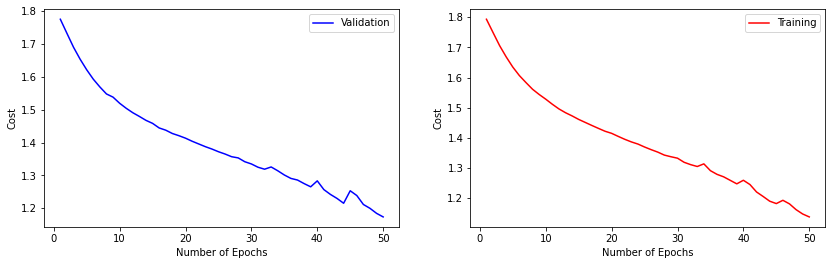

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot([x for x in range(1,len(validation_cost)+1)],validation_cost,color="blue",label="Validation")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Cost")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,len(training_cost)+1)],training_cost,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Cost")
ax[1].legend(loc="best")

plt.show()

In [ ]:
def confusion_matrix(y,pred):
  class_count = len(np.unique(y))
  conf_matrix = np.zeros((class_count,class_count))
  for i in range(len(y)):
    conf_matrix[y[i]][pred[i]] += 1
  return conf_matrix

In [ ]:
def calculate_accuracy(y,pred):
  count = 0
  for i in range(len(y)):
    if y[i] == pred[i]:
      count = count + 1
  return (100 * count / len(y))

In [ ]:
(h,Z1,A1,Z2,A2,Z3,A3_test,d_activation_1,d_activation_2,d_activations_recurrent) = forward_propagation_q3_1(We,x_test)
(h,Z1,A1,Z2,A2,Z3,A3_train,d_activation_1,d_activation_2,d_activations_recurrent) = forward_propagation_q3_1(We,x_train)

In [ ]:
pred_test = np.argmax(A3_test,axis=0)
pred_train = np.argmax(A3_train, axis=0)
y_test_ = np.argmax(y_test,axis=0)
y_train_ = np.argmax(y_train, axis=0)
test_accuracy = calculate_accuracy(y_test_,pred_test)
train_accuracy = calculate_accuracy(y_train_, pred_train)
test_cf = confusion_matrix(y_test_,pred_test)
train_cf = confusion_matrix(y_train_,pred_train)
print(f"Test accuracy:{test_accuracy}")
print(f"Train accuracy:{train_accuracy}")

Test accuracy:49.666666666666664
Train accuracy:58.370370370370374


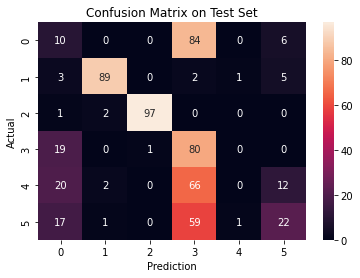

In [ ]:
sns.heatmap(test_cf,annot=True)
plt.title("Confusion Matrix on Test Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

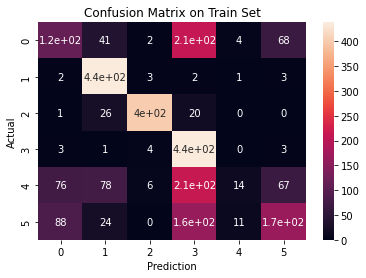

In [ ]:
sns.heatmap(train_cf,annot=True)
plt.title("Confusion Matrix on Train Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

In [ ]:
#Question 3.2
#WX + b
#Parameters determine neuron numbers for related mlp hidden layers
def init_q3_params_2(mlp_first_h_layer_size,mlp_second_h_layer_size):
  #lstm layer, mlp hidden layer, mlp hidden layer, output layer  
  np.random.seed(1)

  #Xavier Uniform Distribution
  recurrent_layer_neuron_size = 128
  output_layer_neuron_size = 6
  input_layer_neuron_size = 3
  stacked_size = recurrent_layer_neuron_size + input_layer_neuron_size

  #lstm related params
  w0 = np.sqrt(6/(recurrent_layer_neuron_size + stacked_size))
  Wf = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, stacked_size))  
  Wi = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, stacked_size)) 
  Wc = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, stacked_size)) 
  Wo = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, stacked_size))
  bf = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  bi = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  bc = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  bo = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))

  #W1 recurrent layer to first mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + recurrent_layer_neuron_size))
  W1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, recurrent_layer_neuron_size))
  b1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, 1))

  #W2 first mlp hidden layer to second mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + mlp_second_h_layer_size))
  W2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size,mlp_first_h_layer_size))
  b2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size, 1))

  #W3 second mlp hidden layer to output layer
  w0 = np.sqrt(6/(output_layer_neuron_size + mlp_second_h_layer_size))
  W3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size,mlp_second_h_layer_size))
  b3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size, 1))

  We = {"Wf":Wf,"Wi":Wi,"Wc":Wc,"Wo":Wo,"bf":bf,"bi":bi,"bc":bc,"bo":bo,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  return We

In [ ]:
def forward_propagate_lstm(We,data):
  Wf = We["Wf"]
  Wc = We["Wc"]
  Wi = We["Wi"]
  Wo = We["Wo"]
  bf = We["bf"]
  bi = We["bi"]
  bc = We["bc"]
  bo = We["bo"]   

  dim,time,samples = data.shape
  recurrent_layer_size = Wf.shape[0]

  #Initialize related variables
  stacked = np.zeros((dim+recurrent_layer_size,time,samples))
  h_prev = np.zeros((recurrent_layer_size, samples))
  c_prev = np.zeros((recurrent_layer_size, samples))  
  c = np.zeros((recurrent_layer_size, time, samples))
  tanhc = np.zeros((recurrent_layer_size, time, samples))
  h_forget = np.zeros((recurrent_layer_size, time, samples))
  h_input = np.zeros((recurrent_layer_size, time, samples))
  h_candidate = np.zeros((recurrent_layer_size, time, samples))
  h_output = np.zeros((recurrent_layer_size, time, samples))
  d_activation_tanhc = np.zeros((recurrent_layer_size, time, samples))
  d_activation_h_forget = np.zeros(((recurrent_layer_size, time, samples)))
  d_activation_h_input = np.zeros(((recurrent_layer_size, time, samples)))
  d_activation_h_candidate = np.zeros(((recurrent_layer_size, time, samples)))
  d_activation_h_output = np.zeros(((recurrent_layer_size, time, samples)))

  for t in range(time):
    stacked[:,t,:] = np.row_stack((h_prev,data[:,t,:]))
    curr_stacked = stacked[:,t,:]

    h_forget[:,t,:], d_activation_h_forget[:,t,:] = activation(np.matmul(Wf,curr_stacked) + bf,"sigmoid")
    h_input[:,t,:], d_activation_h_input[:,t,:] = activation(np.matmul(Wi,curr_stacked) + bi,"sigmoid")
    h_candidate[:,t,:], d_activation_h_candidate[:,t,:] = activation(np.matmul(Wc,curr_stacked) + bc,"tanh")
    h_output[:,t,:], d_activation_h_output[:,t,:] = activation(np.matmul(Wo,curr_stacked) + bo,"sigmoid")

    c[:,t,:] = h_forget[:,t,:] * c_prev + h_input[:,t,:] * h_candidate[:,t,:]
    tanhc[:,t,:],d_activation_tanhc[:,t,:] = activation(c[:,t,:],"tanh")
    h_prev = tanhc[:,t,:] * h_output[:,t,:]
    c_prev = c[:,t,:]

  cache = (stacked,h_prev,c,tanhc,h_forget,h_input,h_candidate,h_output,d_activation_tanhc,d_activation_h_forget,d_activation_h_candidate,d_activation_h_input,d_activation_h_output)
  return cache

In [ ]:
def forward_propagation_q3_2(We, data):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]

  #recurrent layer
  cache = forward_propagate_lstm(We,data)
  A0 = cache[1]#final state

  #relu layers
  Z1 = np.matmul(W1,A0) + b1
  A1, d_activation_1 = activation(Z1,"relu")
  Z2 = np.matmul(W2,A1) + b2
  A2, d_activation_2 = activation(Z2,"relu")

  #softmax layer
  Z3 = np.matmul(W3,A2) + b3
  A3, _ = activation(Z3,"softmax")

  return (Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,cache)

In [ ]:
def cost_q3_2(We,x_train,y_train):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wf = We["Wf"]
  Wi = We["Wi"]
  Wc = We["Wc"]
  Wo = We["Wo"]
  bf = We["bf"]
  bi = We["bi"]
  bc = We["bc"]
  bo = We["bo"]  

  #Forward propagate for training
  (Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,cache) = forward_propagation_q3_2(We,x_train)
  stacked,h_prev,c,tanhc,h_forget,h_input,h_candidate,h_output,d_activation_tanhc,d_activation_h_forget,d_activation_h_candidate,d_activation_h_input,d_activation_h_output = cache

  #Calculate training cost for this batch
  batch_training_cost = cross_entropy_q3(A3,y_train)

  #Backward propagate until recurrent layer    
  dZ3 = A3 - y_train
  dW3 = np.matmul(dZ3,A2.T)
  db3 = np.sum(dZ3,axis=1,keepdims=True)
  dA2 = np.matmul(W3.T,dZ3)
  dZ2 = dA2 * d_activation_2
  dW2 = np.matmul(dZ2,A1.T)
  db2 = np.sum(dZ2,axis=1,keepdims=True)
  dA1 = np.matmul(W2.T,dZ2)
  dZ1 = dA1 * d_activation_1  
  dW1 = np.matmul(dZ1,h_prev.T) #W1 takes final state 
  db1 = np.sum(dZ1,axis=1,keepdims=True)

  #gradient of the final state
  d_state = np.matmul(W1.T,dZ1) #dh(t)
  d_z = d_state

  #Sizes to be used
  dim,time,sample = h_forget.shape

  #initialize gradients regarding lstm layer
  dWf = 0
  dWi = 0
  dWc = 0
  dWo = 0
  dbf = 0
  dbi = 0
  dbc = 0
  dbo = 0

  for t in reversed(range(time)):
    stacked_curr = stacked[:,t,:]   

    if t > 0:
      c_prev = c[:,t-1,:]
    else:
      c_prev = np.zeros((dim,sample))
    
    dc = d_z * h_output[:,t,:] * d_activation_tanhc[:,t,:]
    dhf = dc * c_prev * d_activation_h_forget[:,t,:]
    dhi = dc * h_candidate[:, t, :] * d_activation_h_input[:, t, :]
    dhc = dc * h_input[:, t, :] * d_activation_h_candidate[:, t, :]
    dho = d_z * tanhc[:, t, :] * d_activation_h_output[:, t, :]

    #Sum gradients
    dWf += np.matmul(dhf,stacked_curr.T)
    dWi += np.matmul(dhi,stacked_curr.T)
    dWc += np.matmul(dhc,stacked_curr.T)
    dWo += np.matmul(dho,stacked_curr.T)
    dbf += np.sum(dhf,axis=1,keepdims=True)
    dbi += np.sum(dhi,axis=1,keepdims=True)
    dbc += np.sum(dhc,axis=1,keepdims=True)
    dbo += np.sum(dho,axis=1,keepdims=True)


    #d_z should be updated
    #Since stack is used for weights only pick previous layers
    dxf = np.matmul(Wf.T[:dim,:],dhf)
    dxc = np.matmul(Wc.T[:dim,:],dhc)
    dxi = np.matmul(Wi.T[:dim,:],dhi)
    dxo = np.matmul(Wo.T[:dim,:],dho)

    d_z = dxf + dxc + dxi + dxo

  grads={"dW1":dW1,"dW2":dW2,"dW3":dW3,"db1":db1,"db2":db2,"db3":db3,"dWf":dWf,"dWi":dWi,"dWc":dWc,"dWo":dWo,"dbf":dbf,"dbi":dbi,"dbc":dbc,"dbo":dbo}
  return batch_training_cost, grads

In [ ]:
def update_parameters_q3_2(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wf = We["Wf"]
  Wi = We["Wi"]
  Wc = We["Wc"]
  Wo = We["Wo"]
  bf = We["bf"]
  bi = We["bi"]
  bc = We["bc"]
  bo = We["bo"]  

  delta_W1 = learning_rate * grads["dW1"] + momentum_rate * momentum_dict["cW1"] 
  delta_W2 = learning_rate * grads["dW2"] + momentum_rate * momentum_dict["cW2"] 
  delta_W3 = learning_rate * grads["dW3"] + momentum_rate * momentum_dict["cW3"] 
  delta_b1 = learning_rate * grads["db1"] + momentum_rate * momentum_dict["cb1"] 
  delta_b2 = learning_rate * grads["db2"] + momentum_rate * momentum_dict["cb2"] 
  delta_b3 = learning_rate * grads["db3"] + momentum_rate * momentum_dict["cb3"] 
  delta_Wf = learning_rate * grads["dWf"] + momentum_rate * momentum_dict["cWf"]
  delta_Wi = learning_rate * grads["dWi"] + momentum_rate * momentum_dict["cWi"]
  delta_Wc = learning_rate * grads["dWc"] + momentum_rate * momentum_dict["cWc"]
  delta_Wo = learning_rate * grads["dWo"] + momentum_rate * momentum_dict["cWo"]
  delta_bf = learning_rate * grads["dbf"] + momentum_rate * momentum_dict["cbf"]
  delta_bi = learning_rate * grads["dbi"] + momentum_rate * momentum_dict["cbi"] 
  delta_bc = learning_rate * grads["dbc"] + momentum_rate * momentum_dict["cbc"] 
  delta_bo = learning_rate * grads["dbo"] + momentum_rate * momentum_dict["cbo"]  
  

  #Update
  W1 = W1 - delta_W1
  W2 = W2 - delta_W2
  W3 = W3 - delta_W3
  b1 = b1 - delta_b1
  b2 = b2 - delta_b2
  b3 = b3 - delta_b3
  Wf = Wf - delta_Wf
  Wi = Wi - delta_Wi
  Wc = Wc - delta_Wc
  Wo = Wo - delta_Wo
  bf = bf - delta_bf
  bi = bi - delta_bi
  bc = bc - delta_bc
  bo = bo - delta_bo


  We = {"Wf":Wf,"Wi":Wi,"Wc":Wc,"Wo":Wo,"bf":bf,"bi":bi,"bc":bc,"bo":bo,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  momentum_dict = {"cW1":delta_W1,"cW2":delta_W2,"cW3":delta_W3,"cb1":delta_b1,"cb2":delta_b2,"cb3":delta_b3,"cWf":delta_Wf,"cWi":delta_Wi,"cWc":delta_Wc,"cWo":delta_Wo,"cbf":delta_bf,"cbi":delta_bi,"cbc":delta_bc,"cbo":delta_bo}
  return We,momentum_dict

In [ ]:
def gradient_descent_q3_2(We,epoch,learning_rate,batch_size,x_train,y_train,x_val,y_val,momentum_dict,momentum_rate):
  N = x_train.shape[2]
  iteration_per_epoch = int(N / batch_size)
  validation_cost = []
  training_cost = []
  for i in range(epoch):
    mini_batch_start_index = 0
    mini_batch_end_index = batch_size
    sample_order = np.random.permutation(N)
    x_train_data = x_train[:,:,sample_order]
    y_train_data = y_train[:,sample_order]
    train_per_batch = []        
    for j in range(iteration_per_epoch):      
      mini_batch_data_x = x_train_data[:,:,mini_batch_start_index:mini_batch_end_index]
      mini_batch_data_y = y_train_data[:,mini_batch_start_index:mini_batch_end_index]      
      J,grads = cost_q3_2(We,mini_batch_data_x,mini_batch_data_y)      
      We,momentum_dict = update_parameters_q3_2(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size)
      mini_batch_start_index = mini_batch_end_index
      mini_batch_end_index = mini_batch_end_index + batch_size
      train_per_batch.append(J)
      if mini_batch_end_index > N:
        mini_batch_end_index = N 
    
    #Training cost
    training_cost_per_epoch = np.mean(train_per_batch)
    training_cost.append(training_cost_per_epoch)

    #Forward propagate for validation
    (Z1,A1,Z2,A2,Z3,A3_val,d_activation_1,d_activation_2,cache) = forward_propagation_q3_2(We,x_val)    
    #Calculate validation cost for this batch
    val_cost = cross_entropy_q3(A3_val,y_val)
    print(f"Epoch = {i+1} ---> Validation cost: {val_cost} Training cost:{training_cost_per_epoch}")
    validation_cost.append(val_cost)
    if len(validation_cost) > 1:
      delta_err = np.abs(validation_cost[-1] - validation_cost[-2])
      if delta_err < 1e-5:
        print("Training will be stopped because of low validation delta")

  return We,momentum_dict,validation_cost,training_cost

In [ ]:
We = init_q3_params_2(64,32)
momentum_dict = {"cW1":0,"cW2":0,"cW3":0,"cb1":0,"cb2":0,"cb3":0,"cWf":0,"cWi":0,"cWc":0,"cWo":0,"cbf":0,"cbi":0,"cbc":0,"cbo":0}
We,momentum_dict,validation_cost,training_cost = gradient_descent_q3_2(We,50,0.001,32,x_train,y_train,x_val,y_val,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 1.5340125199983865 Training cost:1.6711603222093796
Epoch = 2 ---> Validation cost: 1.4086656536802953 Training cost:1.4097141539147668
Epoch = 3 ---> Validation cost: 1.3483548061901638 Training cost:1.3268321630595963
Epoch = 4 ---> Validation cost: 1.272205182761711 Training cost:1.2503844086341216
Epoch = 5 ---> Validation cost: 1.129527583008413 Training cost:1.0760737388347337
Epoch = 6 ---> Validation cost: 1.0512875828902317 Training cost:0.9729806914903014
Epoch = 7 ---> Validation cost: 0.9277036215737379 Training cost:0.8853826208233109
Epoch = 8 ---> Validation cost: 0.886024751910107 Training cost:0.8816532000851719
Epoch = 9 ---> Validation cost: 0.8778523805161808 Training cost:0.8381928223659825
Epoch = 10 ---> Validation cost: 0.8723292569597796 Training cost:0.9020794795674595
Epoch = 11 ---> Validation cost: 0.8150317029747786 Training cost:0.7862457202694909
Epoch = 12 ---> Validation cost: 0.7885692560863227 Training cost:0.772237881

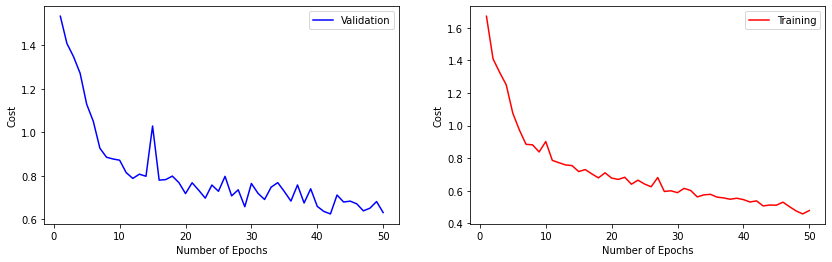

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot([x for x in range(1,len(validation_cost)+1)],validation_cost,color="blue",label="Validation")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Cost")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,len(training_cost)+1)],training_cost,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Cost")
ax[1].legend(loc="best")

plt.show()

In [ ]:
(Z1,A1,Z2,A2,Z3,A3_test,d_activation_1,d_activation_2,cache) = forward_propagation_q3_2(We,x_test)
(Z1,A1,Z2,A2,Z3,A3_train,d_activation_1,d_activation_2,cache) = forward_propagation_q3_2(We,x_train)

In [ ]:
pred_test = np.argmax(A3_test,axis=0)
pred_train = np.argmax(A3_train, axis=0)
y_test_ = np.argmax(y_test,axis=0)
y_train_ = np.argmax(y_train, axis=0)
test_accuracy = calculate_accuracy(y_test_,pred_test)
train_accuracy = calculate_accuracy(y_train_, pred_train)
test_cf = confusion_matrix(y_test_,pred_test)
train_cf = confusion_matrix(y_train_,pred_train)
print(f"Test accuracy:{test_accuracy}")
print(f"Train accuracy:{train_accuracy}")

Test accuracy:67.0
Train accuracy:84.0


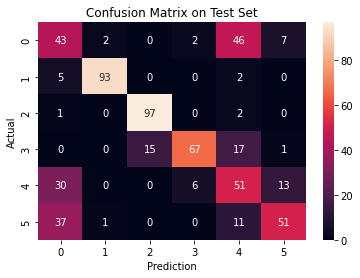

In [ ]:
sns.heatmap(test_cf,annot=True)
plt.title("Confusion Matrix on Test Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

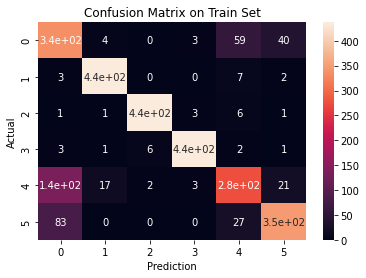

In [ ]:
sns.heatmap(train_cf,annot=True)
plt.title("Confusion Matrix on Train Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

In [ ]:
#Question 3.3
#WX + b
#Parameters determine neuron numbers for related mlp hidden layers
def init_q3_params_3(mlp_first_h_layer_size,mlp_second_h_layer_size):
  #gru layer, mlp hidden layer, mlp hidden layer, output layer  
  np.random.seed(33)

  #Xavier Uniform Distribution
  recurrent_layer_neuron_size = 128
  output_layer_neuron_size = 6
  input_layer_neuron_size = 3  

  #gru related params
  w0 = np.sqrt(6/(recurrent_layer_neuron_size + input_layer_neuron_size))
  w0_ = np.sqrt(6/(recurrent_layer_neuron_size + recurrent_layer_neuron_size))

  Wz = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, input_layer_neuron_size))  
  Wr = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, input_layer_neuron_size)) 
  Wh = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size, input_layer_neuron_size)) 
  
  bz = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  br = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  bh = np.random.uniform(-w0, w0, size=(recurrent_layer_neuron_size,1))
  
  Uz = np.random.uniform(-w0_, w0_, size=(recurrent_layer_neuron_size, recurrent_layer_neuron_size))
  Ur = np.random.uniform(-w0_, w0_, size=(recurrent_layer_neuron_size, recurrent_layer_neuron_size))
  Uh = np.random.uniform(-w0_, w0_, size=(recurrent_layer_neuron_size, recurrent_layer_neuron_size))

  #W1 recurrent layer to first mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + recurrent_layer_neuron_size))
  W1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, recurrent_layer_neuron_size))
  b1 = np.random.uniform(-w0, w0, size=(mlp_first_h_layer_size, 1))

  #W2 first mlp hidden layer to second mlp hidden layer
  w0 = np.sqrt(6/(mlp_first_h_layer_size + mlp_second_h_layer_size))
  W2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size,mlp_first_h_layer_size))
  b2 = np.random.uniform(-w0, w0, size=(mlp_second_h_layer_size, 1))

  #W3 second mlp hidden layer to output layer
  w0 = np.sqrt(6/(output_layer_neuron_size + mlp_second_h_layer_size))
  W3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size,mlp_second_h_layer_size))
  b3 = np.random.uniform(-w0, w0, size=(output_layer_neuron_size, 1))

  We = {"Wz":Wz,"Wr":Wr,"Wh":Wh,"Uz":Uz,"Ur":Ur,"Uh":Uh,"bz":bz,"br":br,"bh":bh,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  return We

In [ ]:
def forward_propagate_gru(We,data):
  Wz = We["Wz"]
  Wr = We["Wr"]
  Wh = We["Wh"]  
  bz = We["bz"]
  br = We["br"]
  bh = We["bh"]
  Uz = We["Uz"]
  Ur = We["Ur"]
  Uh = We["Uh"]     

  dim,time,samples = data.shape
  recurrent_layer_size = Wz.shape[0]

  #Initialize related variables
  h = np.zeros((recurrent_layer_size,time,samples))
  h_prev = np.zeros((recurrent_layer_size, samples))
  z = np.zeros((recurrent_layer_size,time,samples))
  d_activation_z = np.zeros((recurrent_layer_size,time,samples))
  r = np.zeros((recurrent_layer_size,time,samples))
  d_activation_r = np.zeros((recurrent_layer_size,time,samples))
  h_ = np.zeros((recurrent_layer_size,time,samples))
  d_activation_h_ = np.zeros((recurrent_layer_size,time,samples))
  

  for t in range(time):
    x_cur = data[:,t,:]
    z[:,t,:], d_activation_z[:,t,:] = activation(np.matmul(Wz,x_cur) + np.matmul(Uz,h_prev) + bz,"sigmoid")
    r[:,t,:], d_activation_r[:,t,:] = activation(np.matmul(Wr,x_cur) + np.matmul(Ur,h_prev) + br,"sigmoid")
    h_[:,t,:], d_activation_h_[:,t,:] = activation(np.matmul(Wh,x_cur) + np.matmul(Uh,(r[:,t,:] * h_prev)) + bh, "tanh")
    h[:,t,:] = (1 - z[:,t,:]) * h_prev + z[:,t,:] * h_[:,t,:]
    h_prev = h[:,t,:]

  cache = (h,z,d_activation_z,r,d_activation_r,h_,d_activation_h_)
  return cache

In [ ]:
def forward_propagation_q3_3(We, data):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]

  #recurrent layer
  cache = forward_propagate_gru(We,data)
  A0 = cache[0][:,-1,:]#final state

  #relu layers
  Z1 = np.matmul(W1,A0) + b1
  A1, d_activation_1 = activation(Z1,"relu")
  Z2 = np.matmul(W2,A1) + b2
  A2, d_activation_2 = activation(Z2,"relu")

  #softmax layer
  Z3 = np.matmul(W3,A2) + b3
  A3, _ = activation(Z3,"softmax")

  return (Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,cache)

In [ ]:
def cost_q3_3(We,x_train,y_train):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wz = We["Wz"]
  Wr = We["Wr"]
  Wh = We["Wh"]
  Uz = We["Uz"]
  Ur = We["Ur"]
  Uh = We["Uh"]
  bz = We["bz"]
  br = We["br"]
  bh = We["bh"]
   

  #Forward propagate for training
  (Z1,A1,Z2,A2,Z3,A3,d_activation_1,d_activation_2,cache) = forward_propagation_q3_3(We,x_train)
  (h,z,d_activation_z,r,d_activation_r,h_,d_activation_h_) = cache
  h_prev = h[:,-1,:]

  #Calculate training cost for this batch
  batch_training_cost = cross_entropy_q3(A3,y_train)

  #Backward propagate until recurrent layer    
  dZ3 = A3 - y_train
  dW3 = np.matmul(dZ3,A2.T)
  db3 = np.sum(dZ3,axis=1,keepdims=True)
  dA2 = np.matmul(W3.T,dZ3)
  dZ2 = dA2 * d_activation_2
  dW2 = np.matmul(dZ2,A1.T)
  db2 = np.sum(dZ2,axis=1,keepdims=True)
  dA1 = np.matmul(W2.T,dZ2)
  dZ1 = dA1 * d_activation_1  
  dW1 = np.matmul(dZ1,h_prev.T) #W1 takes final state 
  db1 = np.sum(dZ1,axis=1,keepdims=True)

  #gradient of the final state
  d_state = np.matmul(W1.T,dZ1) #dh(t)
  d_z = d_state #this d_z is not related with the parameter of z

  #Sizes to be used
  dim,time,sample = h.shape

  #initialize gradients regarding lstm layer
  dWz = 0
  dWr = 0
  dWh = 0  
  dbz = 0
  dbr = 0
  dbh = 0
  dUz = 0
  dUr = 0
  dUh = 0  

  for t in reversed(range(time)):
    x_cur = x_train[:,t,:]

    if t > 0:
      h_prev = h[:,t-1,:]
    else:
      h_prev = np.zeros((dim,sample))
    
    dz = d_z * d_activation_z[:,t,:] * (h_[:,t,:] - h_prev)
    dh_ = d_z * d_activation_h_[:,t,:] * z[:,t,:]
    dr = np.matmul(Uh.T,dh_) * h_prev * d_activation_r[:,t,:]

    dWz += np.matmul(dz,x_cur.T)
    dUz += np.matmul(dz,h_prev.T)
    dbz += np.sum(dz,axis=1,keepdims=True)

    dWh += np.matmul(dh_,x_cur.T)
    dUh += np.matmul(dh_,h_prev.T)
    dbh += np.sum(dh_,axis=1,keepdims=True)

    dWr += np.matmul(dr,x_cur.T)
    dUr += np.matmul(dr,h_prev.T)
    dbr += np.sum(dr,axis=1,keepdims=True)

    #update d_z
    d1 = d_z * (1-z[:,t,:])
    d2 = np.matmul(Uz.T,dz)
    d3 = np.matmul(Uh.T,dh_) * (r[:,t,:] + h_prev * np.matmul(Ur.T,d_activation_r[:,t,:]))
    d_z = d1 + d2 + d3
    

  grads={"dW1":dW1,"dW2":dW2,"dW3":dW3,"db1":db1,"db2":db2,"db3":db3,"dWz":dWz,"dWr":dWr,"dWh":dWh,"dbz":dbz,"dbr":dbr,"dbh":dbh,"dUz":dUz,"dUr":dUr,"dUh":dUh}
  return batch_training_cost, grads

In [ ]:
def update_parameters_q3_3(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size):
  W1 = We["W1"]
  W2 = We["W2"]
  W3 = We["W3"]
  b1 = We["b1"]
  b2 = We["b2"]
  b3 = We["b3"]
  Wz = We["Wz"]
  Wr = We["Wr"]
  Wh = We["Wh"]  
  bz = We["bz"]
  br = We["br"]
  bh = We["bh"]
  Uz = We["Uz"]
  Ur = We["Ur"]
  Uh = We["Uh"]
    

  delta_W1 = learning_rate * grads["dW1"] + momentum_rate * momentum_dict["cW1"] 
  delta_W2 = learning_rate * grads["dW2"] + momentum_rate * momentum_dict["cW2"] 
  delta_W3 = learning_rate * grads["dW3"] + momentum_rate * momentum_dict["cW3"] 
  delta_b1 = learning_rate * grads["db1"] + momentum_rate * momentum_dict["cb1"] 
  delta_b2 = learning_rate * grads["db2"] + momentum_rate * momentum_dict["cb2"] 
  delta_b3 = learning_rate * grads["db3"] + momentum_rate * momentum_dict["cb3"] 
  delta_Wz = learning_rate * grads["dWz"] + momentum_rate * momentum_dict["cWz"]
  delta_Wr = learning_rate * grads["dWr"] + momentum_rate * momentum_dict["cWr"]
  delta_Wh = learning_rate * grads["dWh"] + momentum_rate * momentum_dict["cWh"]  
  delta_bz = learning_rate * grads["dbz"] + momentum_rate * momentum_dict["cbz"]
  delta_br = learning_rate * grads["dbr"] + momentum_rate * momentum_dict["cbr"] 
  delta_bh = learning_rate * grads["dbh"] + momentum_rate * momentum_dict["cbh"]
  delta_Uz = learning_rate * grads["dUz"] + momentum_rate * momentum_dict["cUz"]
  delta_Ur = learning_rate * grads["dUr"] + momentum_rate * momentum_dict["cUr"]
  delta_Uh = learning_rate * grads["dUh"] + momentum_rate * momentum_dict["cUh"]  
  

  #Update
  W1 = W1 - delta_W1
  W2 = W2 - delta_W2
  W3 = W3 - delta_W3
  b1 = b1 - delta_b1
  b2 = b2 - delta_b2
  b3 = b3 - delta_b3
  Wz = Wz - delta_Wz
  Wr = Wr - delta_Wr
  Wh = Wh - delta_Wh  
  bz = bz - delta_bz
  br = br - delta_br
  bh = bh - delta_bh
  Uz = Uz - delta_Uz
  Ur = Ur - delta_Ur
  Uh = Uh - delta_Uh  


  We = {"Wz":Wz,"Wr":Wr,"Wh":Wh,"Uz":Uz,"Ur":Ur,"Uh":Uh,"bz":bz,"br":br,"bh":bh,"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
  momentum_dict = {"cW1":delta_W1,"cW2":delta_W2,"cW3":delta_W3,"cb1":delta_b1,"cb2":delta_b2,"cb3":delta_b3,"cWz":delta_Wz,"cWr":delta_Wr,"cWh":delta_Wh,"cbz":delta_bz,"cbr":delta_br,"cbh":delta_bh,"cUz":delta_Uz,"cUr":delta_Ur,"cUh":delta_Uh}
  return We,momentum_dict

In [ ]:
def gradient_descent_q3_3(We,epoch,learning_rate,batch_size,x_train,y_train,x_val,y_val,momentum_dict,momentum_rate):
  N = x_train.shape[2]
  iteration_per_epoch = int(N / batch_size)
  validation_cost = []
  training_cost = []

  for i in range(epoch):
    mini_batch_start_index = 0
    mini_batch_end_index = batch_size
    sample_order = np.random.permutation(N)
    x_train_data = x_train[:,:,sample_order]
    y_train_data = y_train[:,sample_order]
    train_per_batch = []    
    for j in range(iteration_per_epoch):      
      mini_batch_data_x = x_train_data[:,:,mini_batch_start_index:mini_batch_end_index]
      mini_batch_data_y = y_train_data[:,mini_batch_start_index:mini_batch_end_index]      
      J,grads = cost_q3_3(We,mini_batch_data_x,mini_batch_data_y)      
      We,momentum_dict = update_parameters_q3_3(We,grads,learning_rate,momentum_dict,momentum_rate,batch_size)
      mini_batch_start_index = mini_batch_end_index
      mini_batch_end_index = mini_batch_end_index + batch_size
      train_per_batch.append(J)
      if mini_batch_end_index > N:
        mini_batch_end_index = N 
    
    #Training cost
    training_cost_per_epoch = np.mean(train_per_batch)
    training_cost.append(training_cost_per_epoch)

    #Forward propagate for validation
    (Z1,A1,Z2,A2,Z3,A3_val,d_activation_1,d_activation_2,cache) = forward_propagation_q3_3(We,x_val)

    #Calculate validation cost for this batch
    val_cost = cross_entropy_q3(A3_val,y_val)
    print(f"Epoch = {i+1} ---> Validation cost: {val_cost} Training cost:{training_cost_per_epoch}")
    validation_cost.append(val_cost)
    if len(validation_cost) > 1:
      delta_err = np.abs(validation_cost[-1] - validation_cost[-2])
      if delta_err < 1e-5:
        print("Training will be stopped because of low validation delta")

  return We,momentum_dict,validation_cost,training_cost

In [ ]:
We = init_q3_params_3(64,32)
momentum_dict = {"cW1":0,"cW2":0,"cW3":0,"cb1":0,"cb2":0,"cb3":0,"cWz":0,"cWr":0,"cWh":0,"cbz":0,"cbr":0,"cbh":0,"cUz":0,"cUr":0,"cUh":0}
We,momentum_dict,validation_cost,training_cost = gradient_descent_q3_3(We,50,0.0005,32,x_train,y_train,x_val,y_val,momentum_dict,0.85)

Epoch = 1 ---> Validation cost: 1.4617140736969618 Training cost:1.523282059171171
Epoch = 2 ---> Validation cost: 1.2806947775007753 Training cost:1.2873897570941384
Epoch = 3 ---> Validation cost: 1.036296595307446 Training cost:1.1091146783397605
Epoch = 4 ---> Validation cost: 0.9530096641539312 Training cost:1.013759798794578
Epoch = 5 ---> Validation cost: 0.9527940703428017 Training cost:0.8488284173825652
Epoch = 6 ---> Validation cost: 0.738796220443622 Training cost:0.7477994654655538
Epoch = 7 ---> Validation cost: 0.7651765247659782 Training cost:0.7180201242076925
Epoch = 8 ---> Validation cost: 0.7146481946743092 Training cost:0.6643805558588668
Epoch = 9 ---> Validation cost: 0.6611175515528322 Training cost:0.6338579667149743
Epoch = 10 ---> Validation cost: 0.7930057363120201 Training cost:0.5997686566634607
Epoch = 11 ---> Validation cost: 0.5928957539072806 Training cost:0.5516640570303534
Epoch = 12 ---> Validation cost: 0.7628687435671627 Training cost:0.5616227493

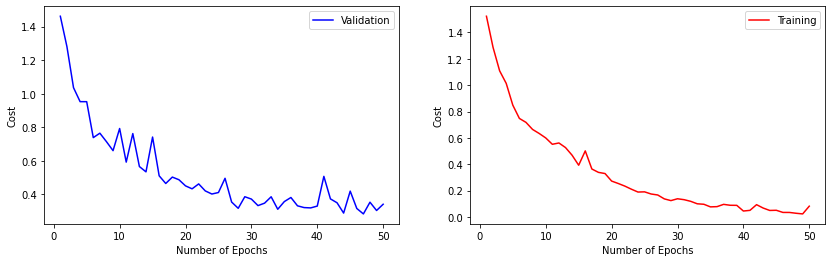

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot([x for x in range(1,len(validation_cost)+1)],validation_cost,color="blue",label="Validation")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Cost")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,len(training_cost)+1)],training_cost,color="red",label="Training")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Cost")
ax[1].legend(loc="best")

plt.show()

In [ ]:
(Z1,A1,Z2,A2,Z3,A3_test,d_activation_1,d_activation_2,cache) = forward_propagation_q3_3(We,x_test)
(Z1,A1,Z2,A2,Z3,A3_train,d_activation_1,d_activation_2,cache) = forward_propagation_q3_3(We,x_train)

In [ ]:
pred_test = np.argmax(A3_test,axis=0)
pred_train = np.argmax(A3_train, axis=0)
y_test_ = np.argmax(y_test,axis=0)
y_train_ = np.argmax(y_train, axis=0)
test_accuracy = calculate_accuracy(y_test_,pred_test)
train_accuracy = calculate_accuracy(y_train_, pred_train)
test_cf = confusion_matrix(y_test_,pred_test)
train_cf = confusion_matrix(y_train_,pred_train)
print(f"Test accuracy:{test_accuracy}")
print(f"Train accuracy:{train_accuracy}")

Test accuracy:83.16666666666667
Train accuracy:97.77777777777777


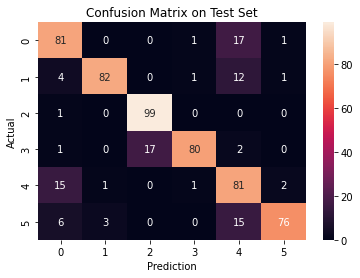

In [ ]:
sns.heatmap(test_cf,annot=True)
plt.title("Confusion Matrix on Test Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

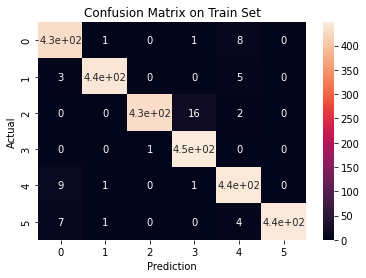

In [ ]:
sns.heatmap(train_cf,annot=True)
plt.title("Confusion Matrix on Train Set")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()